<a href="https://colab.research.google.com/github/lw-miles24/CompModNervSys-final/blob/main/simulate_BallAndStick_soma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll first install neuron as usual.

In [ ]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Run the code block below to mount the google drive folder with the rest of the model files. Save your files in a folder in your main google drive folder and set `drive_folder_name` equal to it as a string. It also compiles the mod files in the `mechanisms` folder

In [ ]:
drive_folder_name = ''
if 'google.colab' in str(get_ipython()):
    import os
    from google.colab import drive
    drive.mount('/content/drive/')
    os.chdir('/content/drive/MyDrive/' + drive_folder_name)
    # Should now be inside drive folder

!nrnivmodl mechanisms

Now we can import the packages we'll be using

In [ ]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib.pyplot as plt
import plotly
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()


Create the Ball and Stick neuron model

In [ ]:
from ballandstick import BallAndStick

ais_mode = 'dend' # set to either 'soma' or 'dend'
ais_loc = 0.6 # 0 to 1, if ais_mode is 'dend', sets how far along the basal dendrite to attach the AIS
cell = BallAndStick(0,ais_mode,ais_loc)

h.topology()
# Time vector
t_vec = h.Vector().record(h._ref_t)
# Simulation parameter settings
h.celsius = 37
h.steps_per_ms = 1/0.025
h.dt = 0.025
h.tstop = 20
h.v_init = -69

# Stimulation
iclamp = h.IClamp(cell.soma(0.5))
iclamp.delay = 5
iclamp.dur = 5
iclamp.amp = 1
iclamp_i = h.Vector().record(iclamp._ref_i)


|-----|       BallAndStick[0].soma(0-1)
       `--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|       BallAndStick[0].dend[0](0-1)
                                                                                                                                `--------------------|       BallAndStick[0].ais_prox(0-1)
                                                                                                                                                      `--------------------|       BallAndStick[0].ais_dist(0-1)
                                                                                                                                                                            `------------------------|       BallAndStick[0].axon(0-1)
       `----------|       BallAndStick[0].dend[1](0-1)
    `--------------------|      

Add excitatory synapse to basal dendritic branch with AIS (`dend[0]`), distal to AIS. Add inhibitory synapse to soma. (see Exercise 9 for detail instructions on how to make synapses)

In [ ]:
# Add excitatory synapse to basal dendrite
exc_syn_loc = 0.8 # 0 to 1, sets how far along basal dendrite excitatory synapse is added
exc_syn = h.Exp2Syn(cell.dend[0](exc_syn_loc))
exc_syn.tau1 = 0.175 # rise time - taken from Hodapp 2022 supp materials
exc_syn.tau2 = 5 # decay time
exc_syn.e = 0 # reversal
# Add inhibitory synapse to soma
inh_syn = h.Exp2Syn(cell.soma(0.5))
inh_syn.tau1 = 1.6
inh_syn.tau2 = 11
inh_syn.e = -75

# synaptic current recordings
exc_syn_i = h.Vector().record(exc_syn._ref_i)
exc_syn_g = h.Vector().record(exc_syn._ref_g)
inh_syn_i = h.Vector().record(inh_syn._ref_i)
inh_syn_g = h.Vector().record(inh_syn._ref_g)

Make `NetStim`s to drive synapses and `NetCons` to connect `NetStim`s to the synapses.  

In [ ]:
# NetStim to simulate excitatory presynaptic spikes
estim = h.NetStim()
estim.number = 1
estim.interval = 10 # interval between spikes
estim.start = 5
estim.noise = 0

# NetCon to connect excitatory presynaptic spikes to excitatory postsynaptic conductance
nc_estim = h.NetCon(estim,exc_syn)
nc_estim.delay = 1 # ms - synaptic delay
nc_estim.weight[0] = 1 # set peak conductance µS

# NetStim to simulate inhibitory presynaptic spikes
istim = h.NetStim()
istim.number = 1
istim.interval = 10 # interval between spikes
istim.start = 10
istim.noise = 0

# NetCon to connect inhibitory presynaptic spikes to excitatory postsynaptic conductance
nc_istim = h.NetCon(istim,inh_syn)
nc_istim.delay = 1 # ms - synaptic delay
nc_istim.weight[0] = 1 # set peak conductance µS

Define helper function to convert between `x` values (normalized distance along a cable) and the segment index (a number between `0` and `nseg-1`) within the dendrite.

In [ ]:
def xind(vec,val):
    # finds closest value to x in x_vals vector, outputs index
    # if x>1, outputs index for x = 1, and if x<0, outputs index for x = 0
    return np.argmin(np.abs(vec-val))

dend0_x_vals = np.array([seg.x for seg in cell.dend[0]])
dend1_x_vals = np.array([seg.x for seg in cell.dend[1]])

Set amplitude of current pulse, excitatory synapse, and/or inhibitory synapse, run, and plot

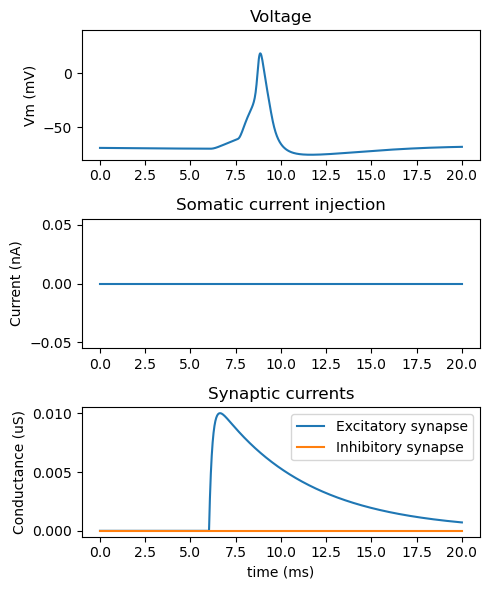

In [ ]:
nc_estim.weight[0] = 0.01
nc_istim.weight[0] = 0
iclamp.amp=0
h.run()

fig = plt.figure(figsize=(5,6))
ax0 = fig.add_subplot(311) # soma voltage
ax0.plot(t_vec,cell.soma_v,label='soma')
# Uncomment to plot other voltages
ax0.plot(t_vec,cell.ais_v,label='Distal AIS')
ax0.plot(t_vec,cell.dend0_vs[xind(dend0_x_vals,0.5)],label='dend[0](0.5)')
ax0.plot(t_vec,cell.dend1_vs[xind(dend1_x_vals,0.5)],label='dend[1](0.5)',ls='--')
# ax0.legend()
ax0.set_ylim(-80,40)
ax0.set_ylabel('Vm (mV)')
ax0.set_title('Voltage')
ax1 = fig.add_subplot(312) # injected current
ax1.plot(t_vec,iclamp_i)
ax1.set_ylabel('Current (nA)')
ax1.set_title('Somatic current injection')
ax2 = fig.add_subplot(313)
ax2.plot(t_vec,exc_syn_g,label='Excitatory synapse')
ax2.plot(t_vec,inh_syn_g,label='Inhibitory synapse')
ax2.set_ylabel('Conductance (uS)')
# ax2.plot(t_vec,exc_syn_i,label='Excitatory synapse')
# ax2.plot(t_vec,inh_syn_i,label='Inhibitory synapse')
ax2.set_xlabel('time (ms)')
ax2.legend()
ax2.set_title('Synaptic currents')
fig.tight_layout()